The below cell is the cie1931 approximate fade path for linear intensity. The two additional functions are needed since the full math lib isn't availble on micropy. 

This code lives on the micro, as the inital intent was to have the project standalone on that micro. It has since grown to allow for arbitarty fade curves and this notebook.

In [1]:

#------------------------------------------------
#micro side


#generate the fade curve
def fillCIETable():
    steps = 4095     #number of steps in the lut
    maxValue = 4095
    cie1931 = []    # pre-calculated PWM levels
  
    #scaling factor to convert from 0-100 to 0-maxValue:
    scalingFactor = 100 / maxValue
  
    #luminance value:
    Y = 0.0
  
    #iterate over the array and calculate the right value for it:
    for l in range(steps+1):
        # you need to scale L from a 0-255 range to a 0-100 range:
        lScaled = l * scalingFactor
        
        if lScaled <= 8:
            Y = (lScaled / 903.3)
        else:
            foo = (lScaled + 16) / 116.0
            Y = pow(foo, 3)
      
        #multiply to get 0-maxValue, and fill in the table:
        #cie1931.append(Y * maxValue)
        cie1931.append(round_nearest_int(Y * maxValue))      
    '''
    for value in cie1931:
        print(value)
    '''
    return cie1931

#ranging
def convert(x, in_min, in_max, out_min, out_max):
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min


#clamping values
def round_nearest_int(x):
    if x >= 0:
        return int(x + 0.5)
    else:
        return int(x - 0.5)



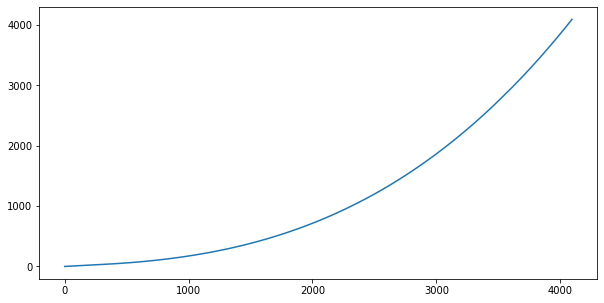

In [2]:
#visualizing the fade path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline

#----------------------------------------------------------------------
#notebook specific. 


ydata = fillCIETable()
ylen = len(ydata)
xdata = np.arange(ylen)


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()

ax.plot(xdata, ydata)


//------------------------------------------------------------------------------------






This is the code to generate an arbitrarty fade, it has 10 input points that are then spline interopleate into 4095 values. This matches the duty cycle resolution on the hardware side. 





//------------------------------------------------------------------------------------

4095
[ 0.5         0.50228601  0.50458234 ... 98.9899398  98.99498605
 99.        ]


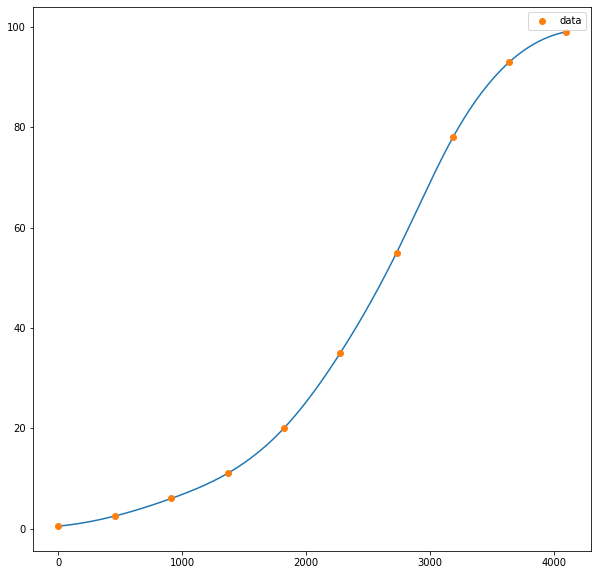

In [3]:
from scipy.interpolate import CubicSpline

#x is considered to be 0-4095, the duty cycle of the pwm output. 
x = np.linspace(0,4095,10)

#y is considered to be 0-100 percent, easy to talk about it..
y = [.5, 2.5, 6., 11., 20., 35., 55., 78.,93.,99]
 
spline = CubicSpline(x, y)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

xnew = np.linspace(0,4095,num=4095)

ax.plot(xnew, spline(xnew))
ax.plot(x, y, 'o', label='data')

print(len(xnew))
print(spline(xnew))

ax.legend(loc='best')

plt.show()




The cell takes the above spline data and converts its range to what the hardware expects, as well dumps it out to a json file. The file name for notebook export and micro import is here. 




In [15]:
#take the generated spline funciton, and chop it into steps for the pwm duty cycle command on teh micro side.
#json is going to get stripped out, memory constraints on the micro

import json
import numpy

#ranging
def r_convert(x):
    in_min = 0
    in_max = 100
    out_min = 0
    out_max = 4100
    r = (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min
    return r



data_out = []

for n in range(4095):
    num = spline(n)
    num = (r_convert(num))
    num = round(num)
    #print(round(num))
    
    data_out.append(num)

#print('data out')
#print(data_out)


'''
with open('output.txt', 'w') as filehandle:
    json.dump(array.toList(), filehandle)
'''

'''
#dump as a json string
json_string = json.dump(data_out)
file = open('spline_pwm_file.json', 'w')
json.dump(data_out, file)
file.close()    
'''

#dump out as the whole array
file = open('spline_pwm_file.txt', 'w')
data_out_string = " ".join(str(x) for x in data_out)
file.write(data_out_string)
file.close()


#dump as a string (is the json parsing the problem? (maybe?)
'''
numArray = numpy.array(numList)
file = open('spline_pwm_file.dat', 'w')
file.close()
'''



"\nnumArray = numpy.array(numList)\nfile = open('spline_pwm_file.dat', 'w')\nfile.close()\n"



This Cell is doing the work of importing the json file, it's is splitting the string allowing for recall of the specific duty cycle values. There is little debugging on the hardware side, this is a pre-check.




In [19]:
f = open('spline_pwm_file.txt')
fstring = f.read()
f.close()

data = fstring.split(' ')

#print(data)
#print(int(data[1]))

print("length of loaded file", len(data))



length of loaded file 4095
